In [1]:
import datetime
import numpy

import pandas as pd
import seaborn as sns

## Summary

> This notebook addresses errors in the indoor/outdoor datasets: (i) **missing readings** and (ii) **timestamp corrections**. The process also outputs the following findings:
* Indoor/outdoor sensor read temperature and humidity **every 10 mins**. 
* Some **readings were lost** probably due to network related issues.
* **Sensors syncrhonize with each other** (i.e., they send data at exactly the same time).
* Sensors were **turn-off** probably for **mantainance or cleansing purposes**. 

## Datasets General Characteristics

In [2]:
indoor  = pd.read_csv("data/indoor.csv")
outdoor = pd.read_csv("data/outdoor.csv")

### Schemas

In [3]:
indoor.head(2)

,Timestamp,Temperature,Humidity
0,1514761200,18.3,50
1,1514761800,18.3,50


In [4]:
outdoor.head(2)

,Timestamp,Temperature,Humidity
0,1514761200,7.7,83
1,1514761800,7.8,83


Both datasets have the same schema: `Temperature` values are measure in celsius degrees. `Humidity` values represent _relative humidity_ and thus are measured in percentage.

### Empty values

In [5]:
indoor.isnull().sum()

Timestamp      0
Temperature    0
Humidity       0
dtype: int64

In [6]:
outdoor.isnull().sum()

Timestamp      0
Temperature    0
Humidity       0
dtype: int64

The original raw datasets does not contain empty values.

### Duration

In [7]:
def duration(df):
    start = datetime.datetime.fromtimestamp(df['Timestamp'].values[0] ) 
    end   = datetime.datetime.fromtimestamp(df['Timestamp'].values[-1])
    
    print('Start time: {}'.format(start))
    print('End time:   {}'.format(end))
    print('Duration:   {}'.format(end - start))

In [8]:
duration(indoor)

Start time: 2017-12-31 23:00:00
End time:   2019-02-27 22:59:05
Duration:   422 days, 23:59:05


In [9]:
duration(outdoor)

Start time: 2017-12-31 23:00:00
End time:   2019-02-27 22:59:05
Duration:   422 days, 23:59:05


Both datasets contain data for the same temporal interval: `422 days`.

## Distribution of Temperature/Humidity Values

In [10]:
def distribution(df, col): 
    print(df[col].describe())
    return sns.lineplot(x='Timestamp', y=col, data=df)

### Temperature RAW values

#### Indoor

count    59321.000000
mean        20.705088
std          2.374757
min         16.000000
25%         19.000000
50%         19.800000
75%         22.300000
max         29.100000
Name: Temperature, dtype: float64


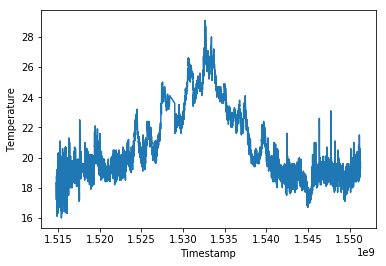

In [11]:
distribution(indoor, 'Temperature')

#### Outdoor

count    60113.000000
mean        10.321393
std          7.692305
min         -9.000000
25%          4.500000
50%          9.100000
75%         16.100000
max         33.600000
Name: Temperature, dtype: float64


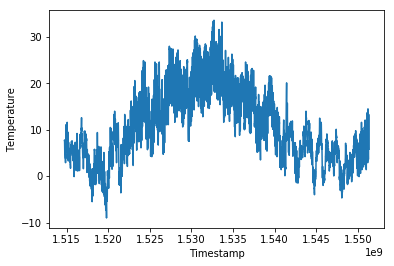

In [12]:
distribution(outdoor, 'Temperature')

### Humidity RAW values

#### Indoor

count    59321.000000
mean        43.716728
std          6.663798
min         17.000000
25%         40.000000
50%         44.000000
75%         48.000000
max         64.000000
Name: Humidity, dtype: float64


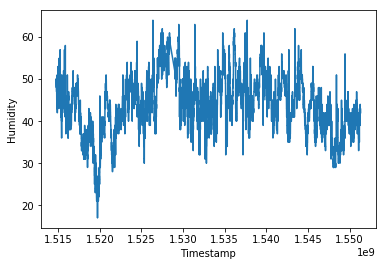

In [13]:
distribution(indoor, 'Humidity')

#### Outdoor

count    60113.000000
mean        85.897560
std         16.962326
min         28.000000
25%         76.000000
50%         93.000000
75%        100.000000
max        100.000000
Name: Humidity, dtype: float64


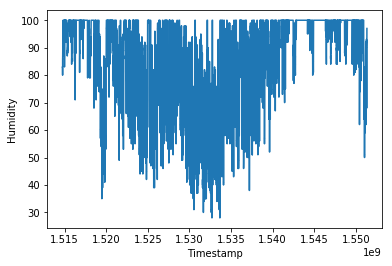

In [14]:
distribution(outdoor, 'Humidity')

### Remarks

The `min`, `max` and overall `distribution of values over time` of indoor and outdoor **temperature/humidity measurements are coherent** to the expected behaviour.

## Addressing Timestamp Anomalies and Missing Readings

### Sensing frequency

Sensors usually collect data at **frequent time intervals** (i.e., the time difference between two consecutive readings is constant).

In [15]:
# Time difference between two consecutive timestamps. The 2dn parameter keeps differences multiple of X (default 1, i.e., all)
def time_intervals(df, multiple=1):
    diff = df['Timestamp'].diff()
    sel  = diff.apply(lambda x: x%multiple==0 )
    return diff[sel].value_counts().sort_index() 

In [16]:
time_intervals(indoor)

598.0           1
599.0           6
600.0       59289
601.0           6
602.0           1
631.0           1
747.0           1
877.0           1
945.0           1
985.0           1
1023.0          1
1063.0          1
1085.0          1
1200.0          3
2844.0          1
87000.0         3
87600.0         1
602945.0        1
Name: Timestamp, dtype: int64

In [17]:
time_intervals(outdoor)

598.0          1
599.0          6
600.0      60052
601.0          6
602.0          1
631.0          1
747.0          1
928.0          1
985.0          1
1023.0         1
1063.0         1
1085.0         1
1200.0        26
1303.0         1
1800.0         4
2172.0         1
3600.0         1
32142.0        1
75466.0        1
87000.0        4
Name: Timestamp, dtype: int64

As shown above, the most frequent interval in both datasets is `600`. This means that both **indoor/outdoor sensors measure temperature/humidity every 600 secs (i.e., every 10 mins)**. 

### Timestamps Correction 

Note that some intervals are numbers near `600` (e.g., `598`, `599`, `601`, `602`). This small differences might be caused by floating point innacuracy or other type of software related issues (e.g., the sensor is busy executing other operations and cannot send the measurement at exaclty 600 secs). This type of clock anomalies can be corrected by adding the missing difference to some timestamps.

In [18]:
def correct_timestamp_anomalies(df, anomalies):
    
    df['timestamp_diff'] = df['Timestamp'].diff()
    
    sel = df['timestamp_diff'].isin(anomalies)
    for i in df[sel].index.values:
        n = df.shape[0]-1
        c = 600 - df.loc[i, 'timestamp_diff'] # correction
        df.loc[i:n, 'Timestamp'] += c
    
    del df['timestamp_diff']
    return df

In [19]:
anomalies = [598, 599, 601, 602]
indoor    = correct_timestamp_anomalies(indoor, anomalies)
outdoor   = correct_timestamp_anomalies(outdoor, anomalies)

In [20]:
time_intervals(indoor)

600.0       59303
631.0           1
747.0           1
877.0           1
945.0           1
985.0           1
1023.0          1
1063.0          1
1085.0          1
1200.0          3
2844.0          1
87000.0         3
87600.0         1
602945.0        1
Name: Timestamp, dtype: int64

In [21]:
time_intervals(outdoor)

600.0      60066
631.0          1
747.0          1
928.0          1
985.0          1
1023.0         1
1063.0         1
1085.0         1
1200.0        26
1303.0         1
1800.0         4
2172.0         1
3600.0         1
32142.0        1
75466.0        1
87000.0        4
Name: Timestamp, dtype: int64

Now the small differences in time are gone.

### Missing readings

Note that some intervals in the previous results are multiples of `600`. This suggests that some **readings are missing**, probably due to wifi/bluetooth communication problems. 

In [22]:
time_intervals(indoor, multiple=600)

600.0      59303
1200.0         3
87000.0        3
87600.0        1
Name: Timestamp, dtype: int64

In [23]:
time_intervals(outdoor, multiple=600)

600.0      60066
1200.0        26
1800.0         4
3600.0         1
87000.0        4
Name: Timestamp, dtype: int64

Let's insert the missing readings:

In [24]:
def insert_missing_readings(df):
    
    # Intervals of reference
    intervals = time_intervals(df, multiple=600).index.values
    intervals = [x for x in intervals if x != 600] # Ignore 600 which is the normal interval
    
    df['timestamp_diff'] = df['Timestamp'].diff()
    sel = df['timestamp_diff'].isin(intervals)
    
    for i, row in df[sel].iterrows():
        lim = int(row['timestamp_diff']/600)
        ts  = df.loc[i-1, 'Timestamp']
        for k in range(1, lim):
            df = df.append({'Timestamp': ts + 600*k}, ignore_index=True)
            
    df = df.sort_values(by='Timestamp').reset_index()
    del df['index']
    del df['timestamp_diff']
    
    df['Timestamp'] = df['Timestamp'].astype(int)
    return df

In [25]:
indoor  = insert_missing_readings(indoor)
outdoor = insert_missing_readings(outdoor)

In [26]:
time_intervals(indoor)

600.0       59890
631.0           1
747.0           1
877.0           1
945.0           1
985.0           1
1023.0          1
1063.0          1
1085.0          1
2844.0          1
602945.0        1
Name: Timestamp, dtype: int64

In [27]:
time_intervals(outdoor)

600.0      60716
631.0          1
747.0          1
928.0          1
985.0          1
1023.0         1
1063.0         1
1085.0         1
1303.0         1
2172.0         1
32142.0        1
75466.0        1
Name: Timestamp, dtype: int64

As you can see above, there are no longer missing readings (i.e., intervals `1200`, `1800`, `3600`, `87000` and `87600` are gone).

### Remarks


Note that **some intervals repeat in both datasets** exaclty the same number of times:

In [28]:
indoor_intervals  = set(time_intervals(indoor).index.values)
outdoor_intervals = set(time_intervals(outdoor).index.values)

intersection = list(indoor_intervals & outdoor_intervals)
intersection.sort()
intersection = [x for x in intersection if x != 600]   # Ignore interval 600, which is the expected value
intersection

[631.0, 747.0, 985.0, 1023.0, 1063.0, 1085.0]

Let's see when this happens:

In [29]:
def intervals_timestamps(df, intervals):
    df = df.copy()
    df['timestamp_diff'] = df['Timestamp'].diff()
    sel  = df['timestamp_diff'].isin( intervals )
    cols = ['Timestamp', 'timestamp_diff']
    df = df[sel][cols]
    df.index = pd.to_datetime(df['Timestamp'], unit='s')
    return df

In [30]:
intervals_timestamps(indoor, intersection)

,Timestamp,timestamp_diff
Timestamp,,
2018-01-18 00:28:05,1516235285,1085.0
2018-04-29 11:40:32,1525002032,747.0
2018-11-19 12:23:48,1542630228,985.0
2018-11-24 09:04:19,1543050259,631.0
2018-12-01 00:42:02,1543624922,1063.0
2019-02-11 07:59:05,1549871945,1023.0


In [31]:
intervals_timestamps(outdoor, intersection)

,Timestamp,timestamp_diff
Timestamp,,
2018-01-18 00:28:05,1516235285,1085.0
2018-04-29 11:40:32,1525002032,747.0
2018-11-19 12:23:48,1542630228,985.0
2018-11-24 09:04:19,1543050259,631.0
2018-12-01 00:42:02,1543624922,1063.0
2019-02-11 07:59:05,1549871945,1023.0


Note how these intervals happen exaclty at the same time. This **evidence suggests that both indoor/outdoor sensors are synchronized some how** (e.g., there is a central device in the house responsable of collecting and sending the data to a remote server). This knowledge can be used for cleaning further the datasets, for instance with linear regresion. Yet, this is out of the scope of this notebook.

Also note than sensors were disconnected at different moments:

In [32]:
def list_difference(l1, l2):
    diff = [ e for e in l1 if e not in l2 and e != 600 ]
    diff.sort()
    return diff

In [33]:
intervals_timestamps(
    indoor, 
    list_difference(indoor_intervals, intersection)
)

,Timestamp,timestamp_diff
Timestamp,,
2018-06-14 17:59:37,1528999177,602945.0
2018-11-04 17:14:14,1541351654,877.0
2018-11-05 12:49:59,1541422199,945.0
2018-11-05 13:47:23,1541425643,2844.0


In [34]:
intervals_timestamps(
    outdoor, 
    list_difference(outdoor_intervals, intersection)
)

,Timestamp,timestamp_diff
Timestamp,,
2018-06-11 16:26:00,1528734360,928.0
2018-06-11 17:22:12,1528737732,2172.0
2018-06-12 10:03:55,1528797835,1303.0
2018-06-13 05:49:37,1528868977,32142.0
2018-11-05 13:57:23,1541426243,75466.0


The indoor and outdoor sensors were disconnected 4 and 5 times, respectively. Note how the dates are closely related (`2018-06-11`, `2018-11-05`). This suggests that **sensors were disconnected for cleansing or mainteinance purposes**.

## Storage

In [35]:
indoor.to_csv ('data/cleaned/indoor-cleaned.csv',  index=False)
outdoor.to_csv('data/cleaned/outdoor-cleaned.csv', index=False)

## ~The End